## Let's download some data:
### [Mouse brain EEL dataset, 440 genes](https://figshare.com/articles/dataset/EEL_mouse_sagittal_440_gene_RNA_spatial_data/20324820)
### [Mouse brain EEL dataset, 168 genes, OPTIONAL](https://figshare.com/ndownloader/files/37552918)
### [Mouse brain scRNA-seq dataset, aggregated](https://storage.googleapis.com/linnarsson-lab-loom/l5_all.agg.loom)

## Import packages

In [ ]:
import napari
import random
import numpy as np
import pandas as pd
from FISHscale.utils import dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import BoneFight.bone_fight as bf
import loompy

## Define data paths

In [2]:
# Paste the paths to the corresponding data files here:
EEL_data_big = ''
EEL_data_small = ''
sc_data = ''

## Choose which EEL dataset will be used

In [3]:
EEL_data = EEL_data_big
print("Total number of molecules: " + str(len(pd.read_parquet(EEL_data))))

Total number of molecules: 11249762


<Axes: xlabel='hamming_distance'>

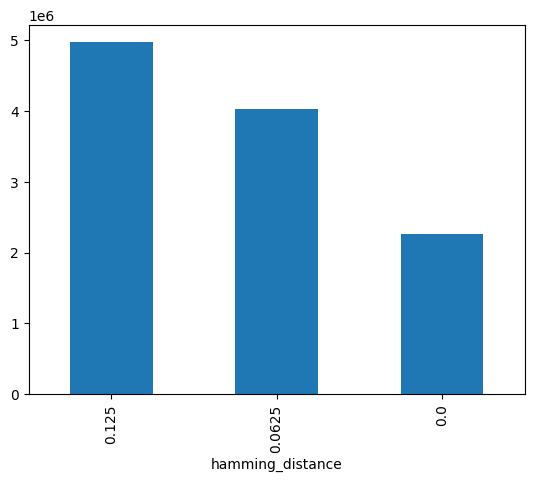

In [4]:
pd.read_parquet(EEL_data)['hamming_distance'].value_counts().plot(kind='bar')

## Plot EEL data using Napari

In [ ]:
# Here we're simply grouping dots by their gene identity, assigning a random color to each group, and adding those points to the Napari viewer
r = lambda: random.randint(0,255)
data = pd.read_parquet(EEL_data)
data = data.loc[data['Valid']==1]
gene_grp = data.groupby('decoded_genes')

viewer = napari.Viewer()
for gene, coords in gene_grp:
    coords = coords.loc[:,['r_px_microscope_stitched','c_px_microscope_stitched']].to_numpy()
    col = '#%02X%02X%02X' % (r(),r(),r())
    _ = viewer.add_points(coords, name=gene, size=6, symbol='o', visible=False, edge_color=col, face_color=col)

## Plot EEL data using FISHscale

In [ ]:
# Here a FISHscale dataset object is created.
d = dataset.Dataset(EEL_data,
                    pixel_size = '0.27 micrometer',
                    exclude_genes = ['Control1', 'Control2', 'Control3', 'Control4', 'Control5', 'Control6', 'Control7', 'Control8', 'Cre'],
                    # If you want to inspect how the control "genes" look, comment out (#) the line above. 
                    verbose = True)

if EEL_data == EEL_data_small:
    d.flip_x()

In [ ]:
# Open the interactive viewer
d.visualize()

## Bin the data into "pseudocell" hexagons

In [6]:
df_hex, labels, hex_coord, df_mean, df_norm = d.regionalize(spacing=75, # You can play around with the size of hexagons by changing 'spacing' value
                                                            min_count=10, 
                                                            n_components=[0,90],
                                                            clust_dist_threshold=100)

print("Number of hexagons: " + str(np.shape(df_hex)[1]))

Number of hexagons: 14100


## Inspect the transcriptomic landscape

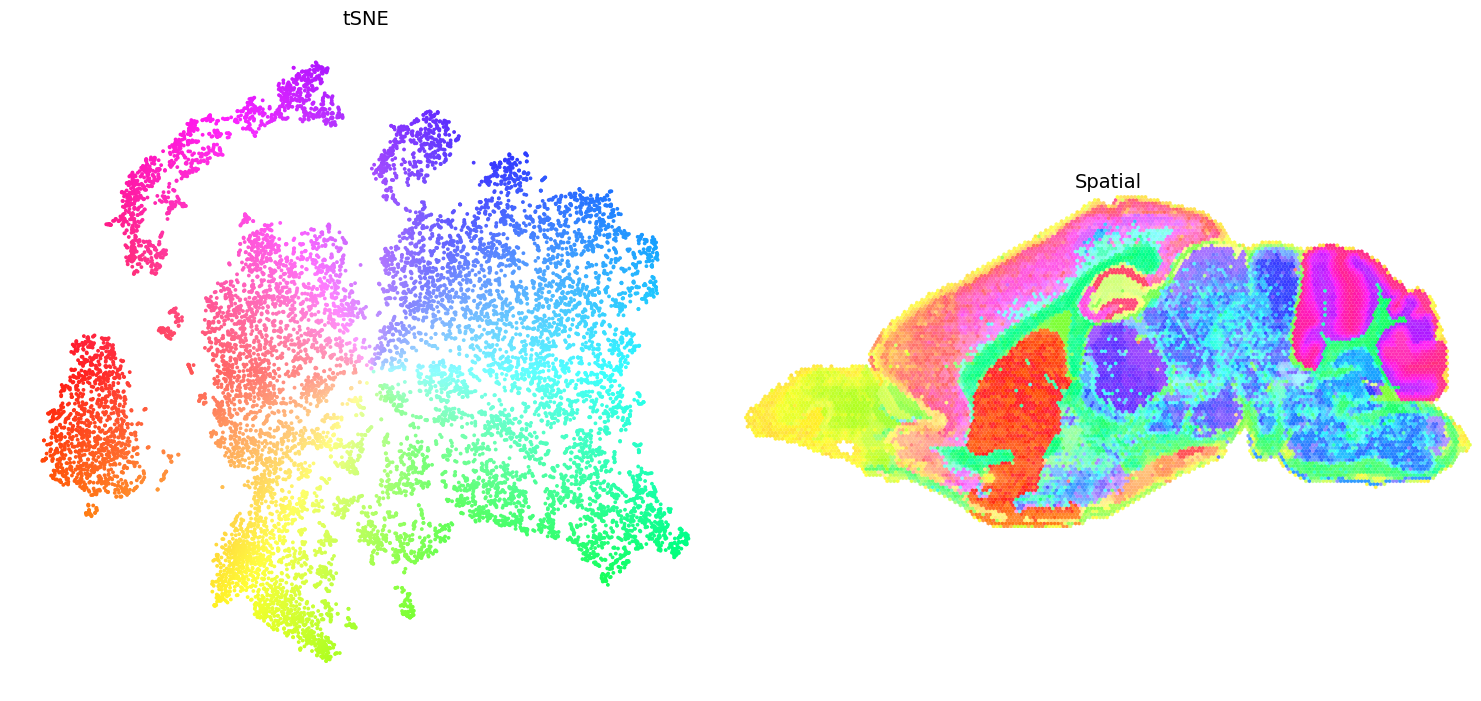

In [7]:
tsne = d.hexbin_tsne_plot(df_hex, components = 2)

## Inspect transcriptomic similarity of regions

Number of regions: 14100


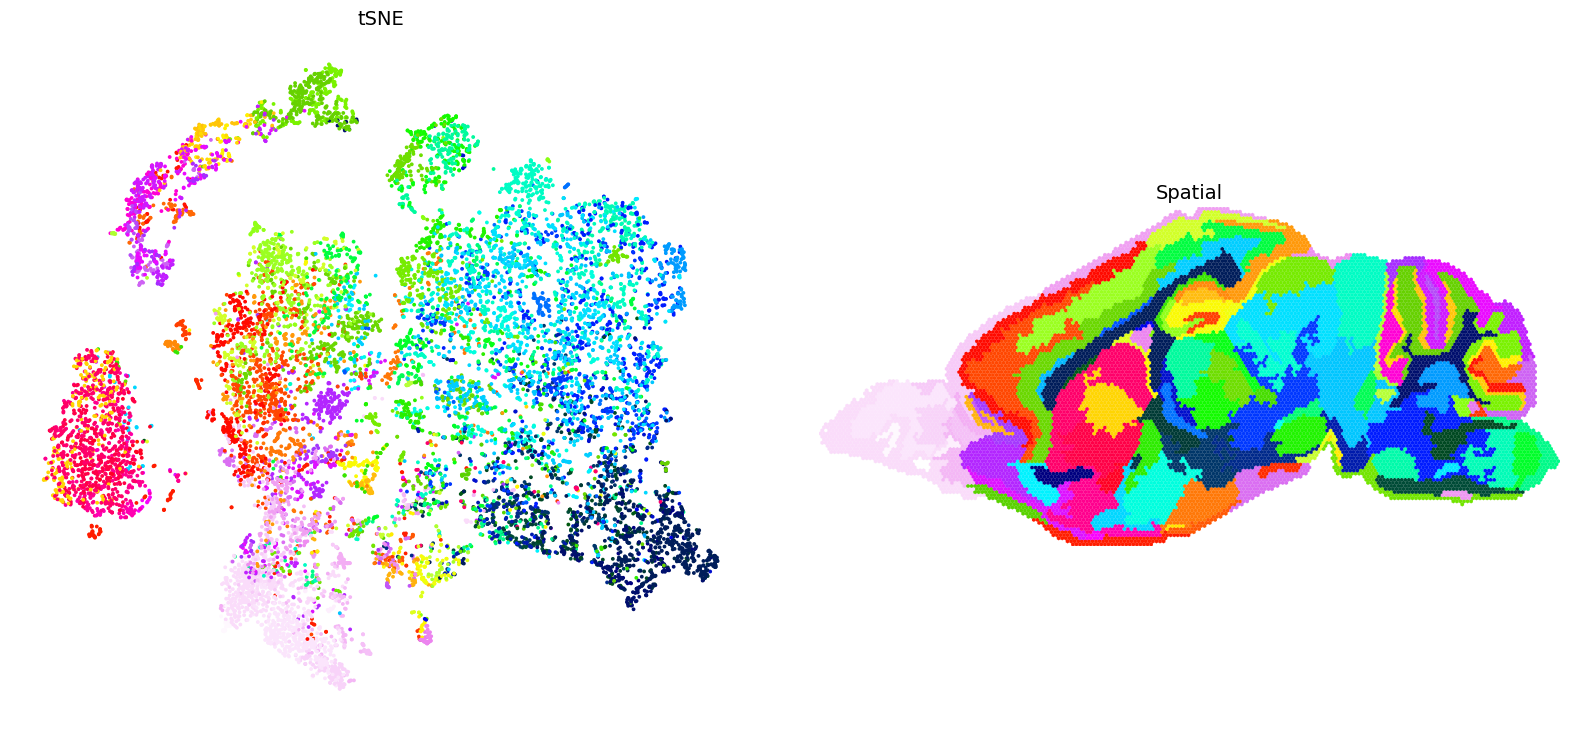

In [8]:
# Set plotting parameters
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[:, 2:])

# Create a shared colormap
labels_scaled = labels - labels.min()
labels_scaled = labels_scaled / labels_scaled.max()
colors = plt.cm.gist_ncar_r(labels_scaled)

# Plot tsne
ax0.scatter(tsne[:,0], tsne[:,1], s=3, c=colors)
ax0.set_aspect('equal')
ax0.set_axis_off()
ax0.set_title('tSNE', fontsize=14)

# Plot spatial
d.hexbin_plot(labels_scaled, cm=plt.cm.gist_ncar_r, ax=ax1)
ax1.set_axis_off()
ax1.set_title('Spatial', fontsize=14)

print("Number of regions: " + str(np.shape(labels)[0]))

## Check which regions have strongest "transcriptomic borders"

2024-06-22 19:52:19,912 - INFO - Computation 1 / 2: 
[########################################] | 100% Completed | 378.46 s
2024-06-22 19:58:39,185 - INFO - Computation 2 / 2: 


/Users/jokubas/Desktop/PhD/Teaching/Summer_School_in_Transcriptomics_2024/FISHscale/FISHscale/spatial/boundaries.py:260: RuntimeWarning: invalid value encountered in divide
  stack = cm_norm * np.nan_to_num((stack / cm_repeat))
/Users/jokubas/Desktop/PhD/Teaching/Summer_School_in_Transcriptomics_2024/FISHscale/FISHscale/spatial/boundaries.py:261: RuntimeWarning: invalid value encountered in divide
  stack_other = cm_norm * np.nan_to_num((stack_other / cm_repeat))


[########################################] | 100% Completed | 9.81 ss


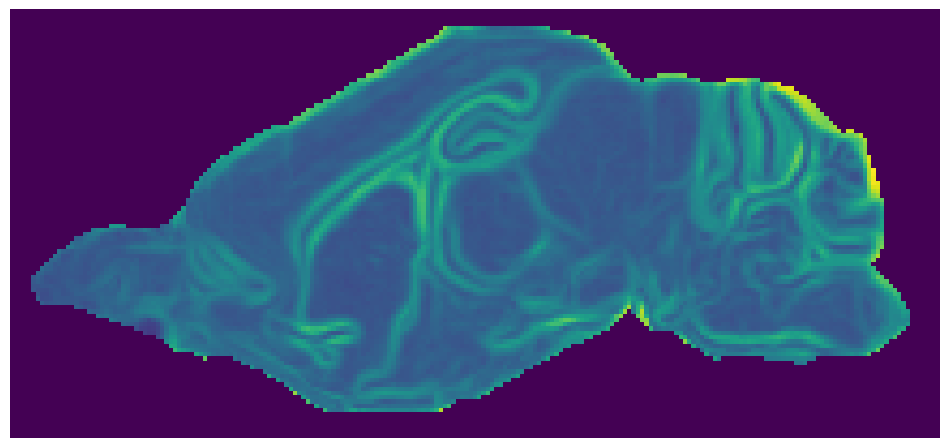

In [9]:
borders, image, grid, grid_filt, filt_grid, shape = d.boundaries_make(bin_size=75, n_angles=12, radius=250, normalize=True, normalization_mode='log')

fig, ax = plt.subplots(figsize=(12,10))

plt.imshow(image)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis();

## Inspect the transcriptomic profiles of regions manually

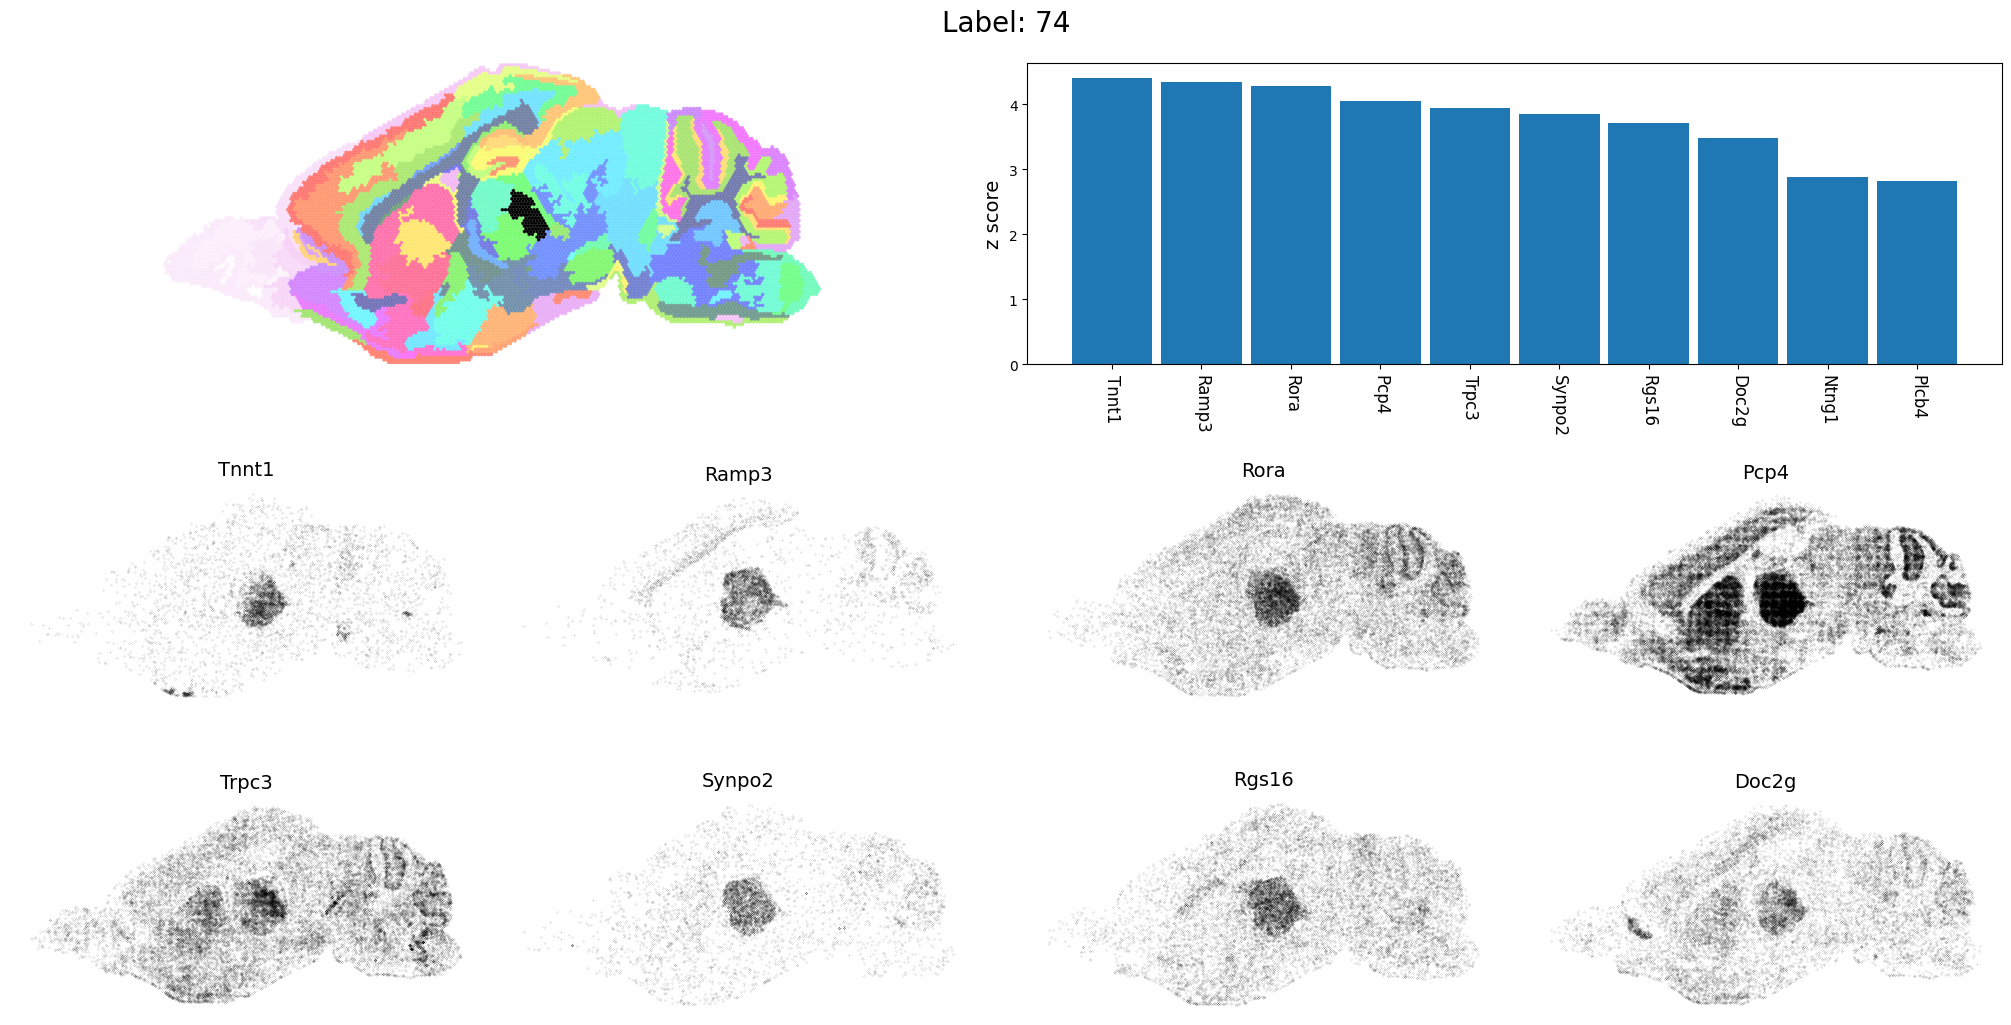

In [10]:
# This provides a summary of regions defined in the previous step. The selected region is highlighted in black.
# The number in the function below corresponds to region ID - change it to select a different region. 
d.region_inspect(74, labels, df_hex, df_mean, df_norm)

## Impute clusters from scRNA-seq

2024-06-22 19:58:56,458 - INFO -     435 matching features between X_1 and X_2


100%|████████████████████████| 100/100 [00:20<00:00,  4.91it/s, loss=-1.2625155]


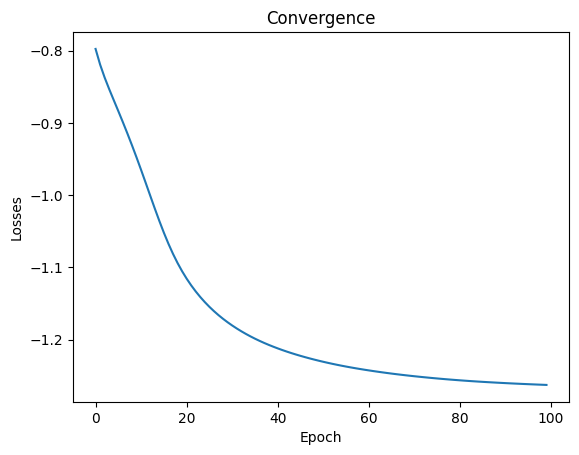

In [11]:
# Connect to the single-cell aggregate dataset
with loompy.connect(sc_data) as ds:

    # Select matching genes
    gene_filt = np.isin(ds.ra.Gene, df_hex.index.to_numpy())
    
    # Exclude non-brain regions. You can try modifying the list to see how it affects the results
    exclude_region = ['Enteric nervous system', 'Sympathetic ganglion', 'Dorsal root ganglion', 'Spinal cord', 'Dorsal root ganglion,Sympathetic ganglion' ]
    region_filt = np.isin(ds.ca.Region, exclude_region, invert=True)
    
    # Select data based on regions and genes
    wb_data=ds[:,:][gene_filt, :]
    wb_data = wb_data[:,region_filt]
    wb_genes = ds.ra.Gene[gene_filt]
    
    # Cluster names
    cluster_name_dict = dict(zip(ds.ca.ClusterName[region_filt], range(len(ds.ca.ClusterName[region_filt]))))
    cluster_description_dict = dict(zip(ds.ca.ClusterName[region_filt], (ds.ca.Description[region_filt])))
    
    # Make the dataframe
    wb_df = pd.DataFrame(wb_data, index = wb_genes, columns=ds.ca.ClusterName[region_filt])
    
    # Size input for the single cell data is the number of cells per cluster.
    wb_size = ds.ca.NCells[region_filt]
    
    # Size input for the spatial data is an array of ones because the hexagons are all equal in size.
    hb_size_equal = np.ones(df_hex.shape[1])

    # Create the model. You can try setting 'num_epochs' to something lower to see how it affects the results
    model, y = d.bonefight(wb_df, wb_size, X_2=df_hex, volume_2=hb_size_equal, plot=True, transform=True, num_epochs=100)

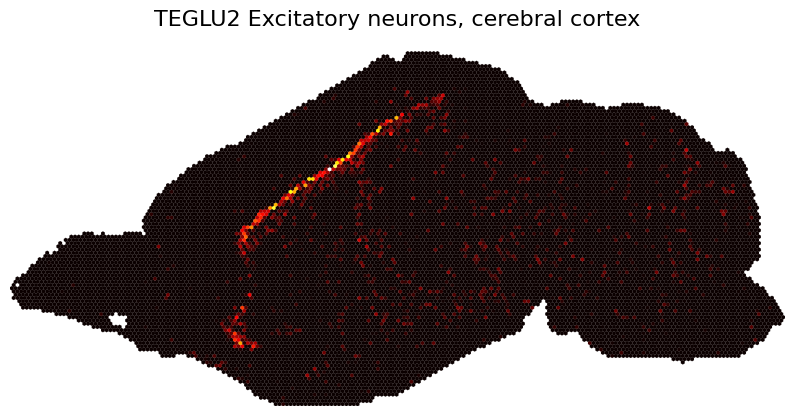

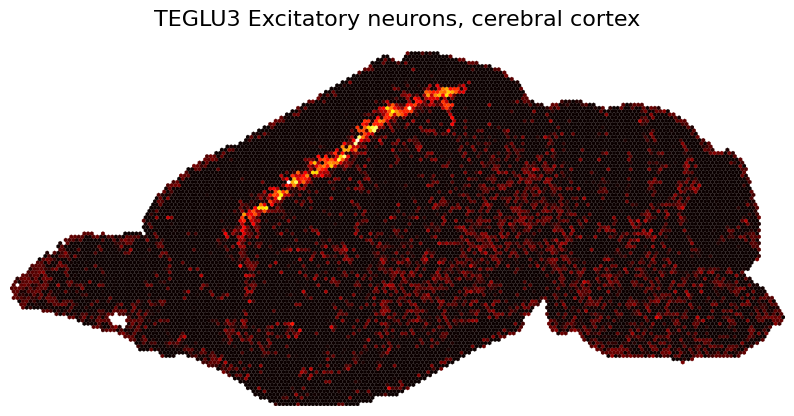

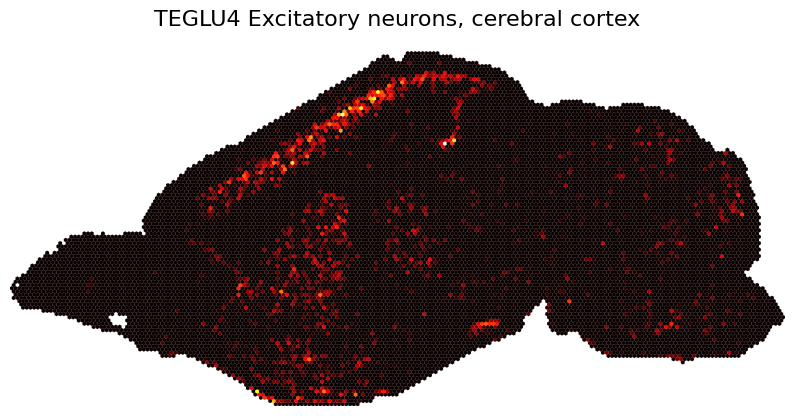

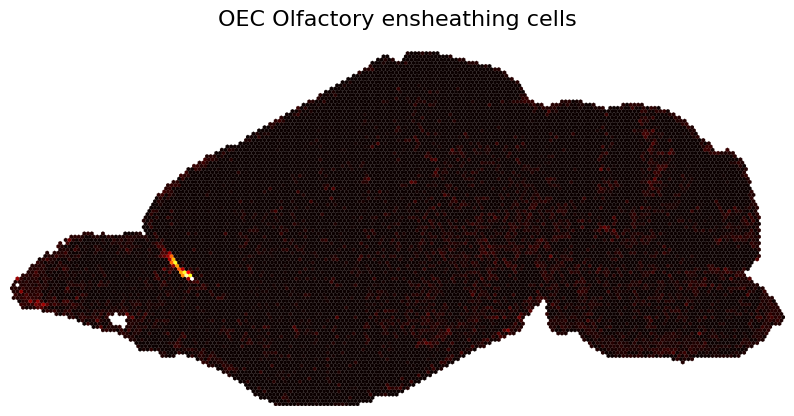

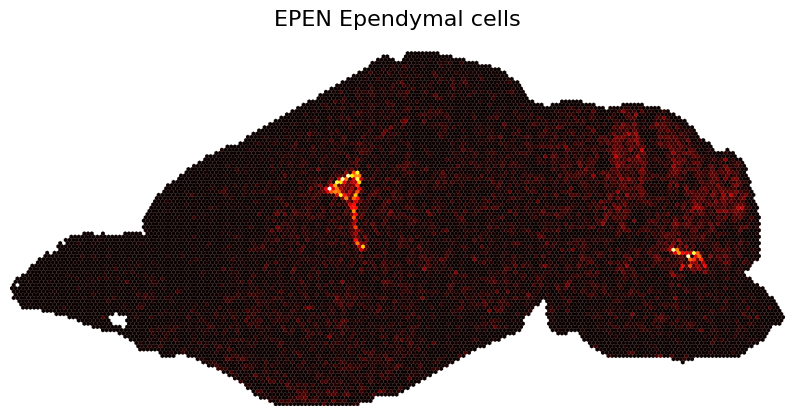

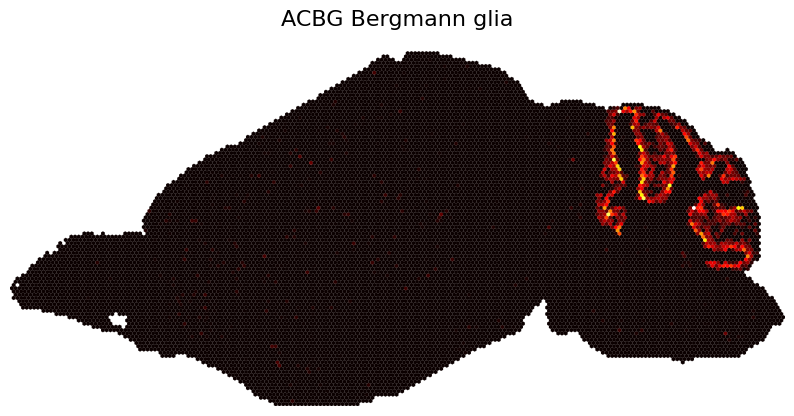

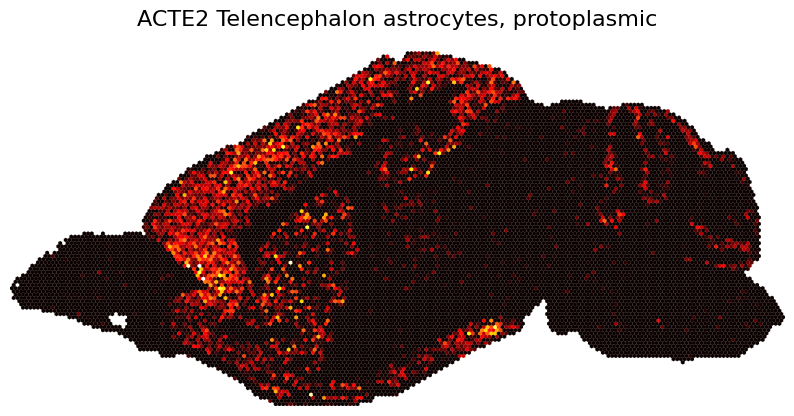

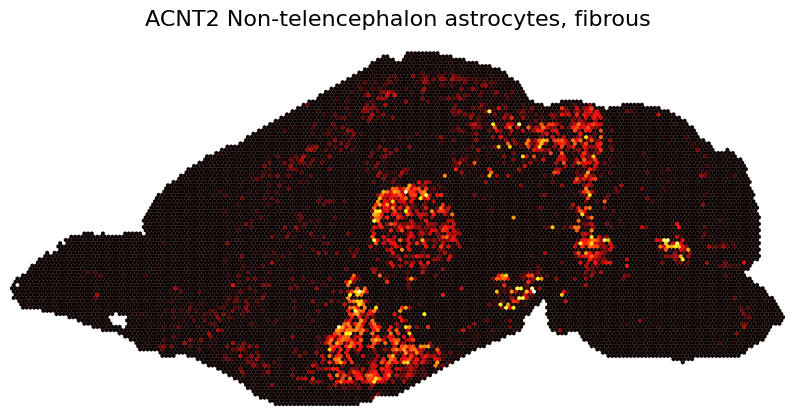

In [12]:
# Plot a few example cluster spatial probabilities
cortex_layers = ['TEGLU2', 'TEGLU3', 'TEGLU4', 'OEC', 'EPEN','ACBG', 'ACTE2', 'ACNT2']

for cluster in cortex_layers:

    idx = np.where(wb_df.columns==cluster)[0][0]
    
    # Get max value to normalize for each plot
    max_y = y[:,idx].max()
    
    d.hexbin_plot(y[:,idx], vmin=0, vmax=max_y, cm=plt.cm.hot)
    
    plt.axis('off')
    cluster_desctription = cluster_description_dict[cluster]
    plt.title(f'{cluster} {cluster_desctription}', fontsize=16, y=1.05)

## Impute gene expression from EEL data

Pitx3 was measured by original EEL dataset: False
Ppp1r1b was measured by original EEL dataset: False
Six3 was measured by original EEL dataset: False


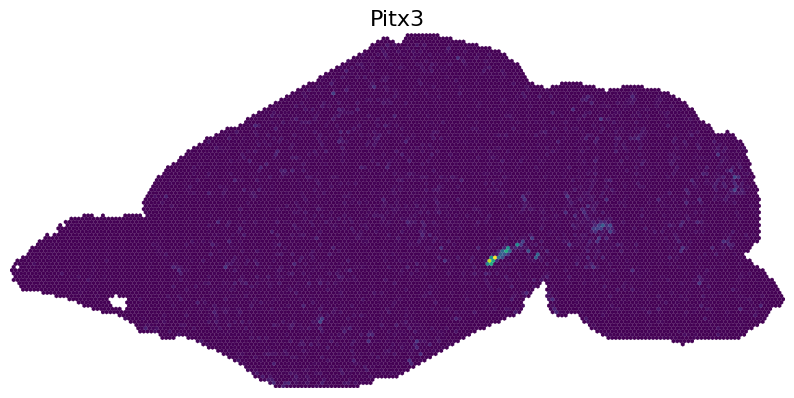

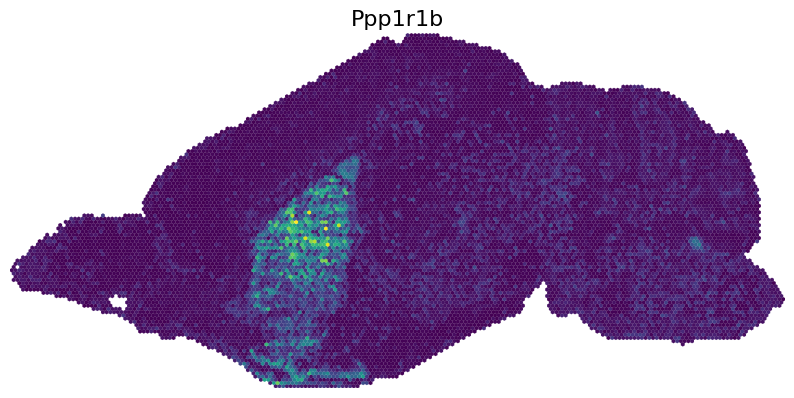

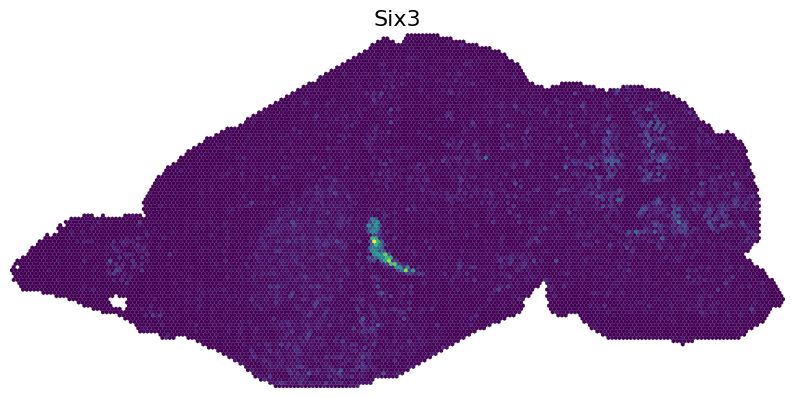

In [13]:
#Plot the imputed spatial gene expression of a gene
genes = ['Pitx3', 'Ppp1r1b', 'Six3']

# Connect to the single-cell aggregate dataset
with loompy.connect(sc_data) as ds:
    for gene in genes:
        # Get the full single cell dataset
        wb_data_full= ds[:,:][:, region_filt]
        
        # Impute spatial gene expression
        y_full = model.transform(wb_data_full.T)
        
        #Test if gene was measured (True) or imputed (False)
        print(f'{gene} was measured by original EEL dataset: {np.isin(gene, d.unique_genes)}')
        
        # Get index of gene
        gene_index = np.where(ds.ra.Gene == gene)[0][0]
        
        # Plot imputed gene expression
        d.hexbin_plot(y_full[:, gene_index])
        
        plt.title(gene, fontsize=16)
        plt.axis('off');
